In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import sys

import matplotlib.pyplot as plt  
import seaborn as sns
import figures as figs
import calculations
from types import SimpleNamespace
import pandas as pd

# Ploting jacobians wrt ptilde
from matplotlib.ticker import FormatStrFormatter

import gc  # For garbage collection
import itertools


from seaborn import set_palette
from matplotlib import rc
plt.style.use('seaborn-v0_8-white')
set_palette("colorblind")
rc('font',**{'family':'serif','serif': ['Palatino']})
rc('text',usetex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# Should make insure text size in latex mode
# plt.rcParams.update({
#     "text.latex.preamble": r"\usepackage{palatino} \normalsize"
# })

from IHANKModel import IHANKModelClass



In [2]:
model_NH = IHANKModelClass()
save_figs = False
shock = calculations.difine_shocks(model_NH, scale=0.3, rho = 0.8)[0]
T_max_ = T_max = 20

In [6]:
model_NH = IHANKModelClass(name='PIGL')
# model_NH.par.mon_policy = 'taylor'



# # c. income model_.parameters
# model_NH.par.rho_z = 0.95 # AR(1) model_.parameter
# model_NH.par.sigma_psi = 0.10 # std. of psi

# model_NH.par.epsilon = 0.22
# model_NH.par.gamma = 0.18
# model_NH.par.kappa = 1.0

model_NH.find_ss()
# model_NH.compute_jacs(do_print=False)
# model_NH.find_transition_path(shocks=shock, do_end_check=False, do_print=False)

In [8]:
model_new = IHANKModelClass(name='New inc')
# model_new.par.mon_policy = 'taylor'


# # c. income model_.parameters
# model_new.par.rho_z = 0.95 # AR(1) model_.parameter
# model_new.par.sigma_psi = 0.10 # std. of psi

In [7]:
model_CD = IHANKModelClass(name='CD')
# model_CD.par.mon_policy = 'taylor'
model_CD.par.epsilon = 0.0
model_CD.par.gamma = 0.0

# model_CD.par.rho_z = 0.95 # AR(1) model_.parameter
# model_CD.par.sigma_psi = 0.10 # std. of psi


# model_CD.par.kappa = 1.0

model_CD.find_ss()
# model_CD.compute_jacs(do_print=False)
# model_CD.find_transition_path(shocks=shock, do_end_check=False, do_print=False)

In [10]:
print(model_NH.ss.CE)
print(model_CD.ss.CE)

0.0671905289352821
0.06618927752616603


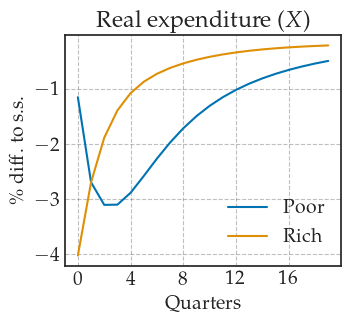

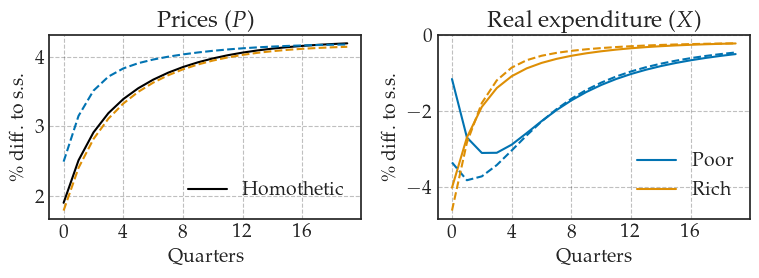

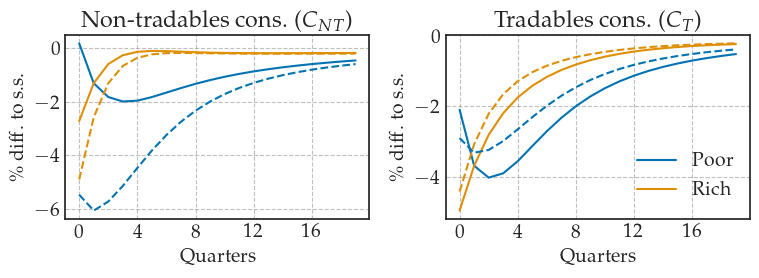

In [5]:
fig_1, fig_2, fig_3 = figs.show_states(model_CD, shock, model_NH)

In [17]:

# def IRF_cohort(model,  shock, model_homo= None, states=None, T_max=16):
def IRF_cohort_dots(model,  shock, model_homo= None, states=None):
    if states is None:
        states = {
            'Poor': [0, 0, 0],   # original values
            'Rich': [0, 6, 300]
        }

    # Precompute SS and JAC once for each base model
    model_base = model.copy(name=model.name)
    model_base.find_ss()
    model_base.compute_jacs()

    if model_homo != None:
        model_base_homo = model_homo.copy(name=model_homo.name)
        model_base_homo.find_ss()
        model_base_homo.compute_jacs()

    # Initialize result dictionaries
    CT_diff, CNT_diff, E_hh_diff, Q_diff, X_diff = {}, {}, {}, {}, {}
    CT_diff_homo, CNT_diff_homo, E_hh_diff_homo, Q_diff_homo, X_diff_homo = {}, {}, {}, {}, {}

    for state in states:
        # === Build normalized Dbeg_choice using both 0 and 1 in the first dimension
        s0, s1, s2 = states[state]
        Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
        for i in [0, 1]:
            Dbeg_choice[i, s1, s2] = 1.0
        Dbeg_choice /= Dbeg_choice.sum()

        # === Standard model
        model_ns = model_base.copy(name='NoShock')
        model_ns.find_transition_path(shocks=[],  do_end_check=False)
        model_ns.simulate_hh_path(Dbeg=Dbeg_choice)
        model_ns.calc_additional_new()

        model_s = model_base.copy(name='Shock')
        model_s.find_transition_path(shocks=shock, do_end_check=False)
        model_s.simulate_hh_path(Dbeg=Dbeg_choice)
        model_s.calc_additional_new()

        CT_diff[state] = (model_s.path.CT_hh - model_ns.path.CT_hh) / model_ns.path.CT_hh * 100
        CNT_diff[state] = (model_s.path.CNT_hh - model_ns.path.CNT_hh) / model_ns.path.CNT_hh * 100
        E_hh_diff[state] = (model_s.path.E_hh - model_ns.path.E_hh) / model_ns.path.E_hh * 100
        Q_diff[state] = (model_s.path.Q_hh - model_ns.path.Q_hh) / model_ns.path.Q_hh * 100
        X_diff[state] = (model_s.path.X_hh - model_ns.path.X_hh) / model_ns.path.X_hh * 100

        del model_ns, model_s
        gc.collect()

        if model_homo != None:

            # === Homo model
            model_ns_homo = model_base_homo.copy(name='NoShock Homo')
            model_ns_homo.find_transition_path(shocks=[],  do_end_check=False)
            model_ns_homo.simulate_hh_path(Dbeg=Dbeg_choice)
            model_ns_homo.calc_additional_new()

            model_s_homo = model_base_homo.copy(name='Shock Homo')
            model_s_homo.find_transition_path(shocks=shock, do_end_check=False)
            model_s_homo.simulate_hh_path(Dbeg=Dbeg_choice)
            model_s_homo.calc_additional_new()

            CT_diff_homo[state] = (model_s_homo.path.CT_hh - model_ns_homo.path.CT_hh) / model_ns_homo.path.CT_hh * 100
            CNT_diff_homo[state] = (model_s_homo.path.CNT_hh - model_ns_homo.path.CNT_hh) / model_ns_homo.path.CNT_hh * 100
            E_hh_diff_homo[state] = (model_s_homo.path.E_hh - model_ns_homo.path.E_hh) / model_ns_homo.path.E_hh * 100
            Q_diff_homo[state] = (model_s_homo.path.Q_hh - model_ns_homo.path.Q_hh) / model_ns_homo.path.Q_hh * 100
            X_diff_homo[state] = (model_s_homo.path.X_hh - model_ns_homo.path.X_hh) / model_ns_homo.path.X_hh * 100

            del model_ns_homo, model_s_homo
            gc.collect()

    # === Plotting

    ncols, nrows = 2, 3
    fig = plt.figure(figsize=(4.3 * ncols / 1.05, 3.6 * nrows / 1.1), dpi=100)

    # Assign consistent colors to states using a colormap
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    state_colors = {state: next(color_cycle) for state in states}

    def plot_panel(ax, title, diff, diff_homo):
        ax.set_title(title)
        for state in states:
            color = state_colors[state]
            ax.scatter(range(T_max), diff[state][:T_max], label=f'{state} Baseline', color=color, marker='o')
            if model_homo is not None:
                ax.scatter(range(T_max), diff_homo[state][:T_max], label=f'{state} Alternative', color=color, marker='x')
        ax.set_xlabel('Quarters')
        ax.set_ylabel('% diff. to s.s.')


    # Plot layout
    ax0 = fig.add_subplot(nrows, ncols, 4)
    plot_panel(ax0, 'Consumption T', CT_diff, CT_diff_homo)
    

    ax1 = fig.add_subplot(nrows, ncols, 3)
    plot_panel(ax1, 'Consumption NT', CNT_diff, CNT_diff_homo)

    ax2 = fig.add_subplot(nrows, ncols, 1)
    plot_panel(ax2, 'P', Q_diff, Q_diff_homo)

    ax3 = fig.add_subplot(nrows, ncols, 2)
    plot_panel(ax3, 'X', X_diff, X_diff_homo)

    ax4 = fig.add_subplot(nrows, ncols, 5)
    plot_panel(ax4, 'A', E_hh_diff, E_hh_diff_homo)

    # legened outside box 
    ax0.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    return fig

# fig = IRF_cohort_old(model_NH, shock, model_homo=model_old)
# fig = IRF_cohort_old(model_old, shock, model_homo=model_old_CD)


In [3]:

# def IRF_cohort(model,  shock, model_homo= None, states=None, T_max=16):
def IRF_cohort_old(model,  shock, model_homo= None, states=None):
    if states is None:
        states = {
            'Poor': [0, 0, 0],   # original values
            'Rich': [0, 6, 300]
        }

    # Precompute SS and JAC once for each base model
    model_base = model.copy(name=model.name)
    model_base.find_ss()
    model_base.compute_jacs()

    if model_homo != None:
        model_base_homo = model_homo.copy(name=model_homo.name)
        model_base_homo.find_ss()
        model_base_homo.compute_jacs()

    # Initialize result dictionaries
    CT_diff, CNT_diff, E_hh_diff, Q_diff, X_diff= {}, {}, {}, {}, {}
    CT_diff_homo, CNT_diff_homo, E_hh_diff_homo, Q_diff_homo, X_diff_homo = {}, {}, {}, {}, {}

    for state in states:
        # === Build normalized Dbeg_choice using both 0 and 1 in the first dimension
        s0, s1, s2 = states[state]
        Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
        for i in [0, 1]:
            Dbeg_choice[i, s1, s2] = 1.0
        Dbeg_choice /= Dbeg_choice.sum()

        # === Standard model
        model_ns = model_base.copy(name='NoShock')
        model_ns.find_transition_path(shocks=[],  do_end_check=False)
        model_ns.simulate_hh_path(Dbeg=Dbeg_choice)
        model_ns.calc_additional_new()

        model_s = model_base.copy(name='Shock')
        model_s.find_transition_path(shocks=shock, do_end_check=False)
        model_s.simulate_hh_path(Dbeg=Dbeg_choice)
        model_s.calc_additional_new()

        CT_diff[state] = (model_s.path.CT_hh - model_ns.path.CT_hh) / model_ns.path.CT_hh * 100
        CNT_diff[state] = (model_s.path.CNT_hh - model_ns.path.CNT_hh) / model_ns.path.CNT_hh * 100
        E_hh_diff[state] = (model_s.path.E_hh - model_ns.path.E_hh) / model_ns.path.E_hh * 100
        Q_diff[state] = (model_s.path.Q_hh - model_ns.path.Q_hh) / model_ns.path.Q_hh * 100
        X_diff[state] = (model_s.path.X_hh - model_ns.path.X_hh) / model_ns.path.X_hh * 100

        

        del model_ns, model_s
        gc.collect()

        if model_homo != None:

            # === Homo model
            model_ns_homo = model_base_homo.copy(name='NoShock Homo')
            model_ns_homo.find_transition_path(shocks=[],  do_end_check=False)
            model_ns_homo.simulate_hh_path(Dbeg=Dbeg_choice)
            model_ns_homo.calc_additional_new()

            model_s_homo = model_base_homo.copy(name='Shock Homo')
            model_s_homo.find_transition_path(shocks=shock, do_end_check=False)
            model_s_homo.simulate_hh_path(Dbeg=Dbeg_choice)
            model_s_homo.calc_additional_new()

            CT_diff_homo[state] = (model_s_homo.path.CT_hh - model_ns_homo.path.CT_hh) / model_ns_homo.path.CT_hh * 100
            CNT_diff_homo[state] = (model_s_homo.path.CNT_hh - model_ns_homo.path.CNT_hh) / model_ns_homo.path.CNT_hh * 100
            E_hh_diff_homo[state] = (model_s_homo.path.E_hh - model_ns_homo.path.E_hh) / model_ns_homo.path.E_hh * 100
            Q_diff_homo[state] = (model_s_homo.path.Q_hh - model_ns_homo.path.Q_hh) / model_ns_homo.path.Q_hh * 100
            X_diff_homo[state] = (model_s_homo.path.X_hh - model_ns_homo.path.X_hh) / model_ns_homo.path.X_hh * 100


            del model_ns_homo, model_s_homo
            gc.collect()

    # === Plotting

    ncols, nrows = 2, 2
    fig = plt.figure(figsize=(4.3 * ncols / 1.05, 3.6 * nrows / 1.1), dpi=100)

    # Assign consistent colors to states using a colormap
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    state_colors = {state: next(color_cycle) for state in states}

    def plot_panel(ax, title, diff, diff_homo):
        ax.set_title(title)
        for state in states:
            color = state_colors[state]
            ax.plot(diff[state][:T_max], label=f'{state} Baseline', linestyle='-', color=color)
            if model_homo != None:
                ax.plot(diff_homo[state][:T_max], label=f'{state} Alternative', linestyle='--', color=color)
        ax.set_xlabel('Quarters')
        ax.set_ylabel('% diff. to s.s.')


    # Plot layout
    ax0 = fig.add_subplot(nrows, ncols, 4)
    plot_panel(ax0, 'Consumption T', CT_diff, CT_diff_homo)
    

    ax1 = fig.add_subplot(nrows, ncols, 3)
    plot_panel(ax1, 'Consumption NT', CNT_diff, CNT_diff_homo)

    ax2 = fig.add_subplot(nrows, ncols, 1)
    plot_panel(ax2, 'P', Q_diff, Q_diff_homo)

    ax3 = fig.add_subplot(nrows, ncols, 2)
    plot_panel(ax3, 'X', X_diff, X_diff_homo)






    # legened outside box 
    ax0.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    return fig

# fig = IRF_cohort_old(model_NH, shock, model_homo=model_old)
# fig = IRF_cohort_old(model_old, shock, model_homo=model_old_CD)


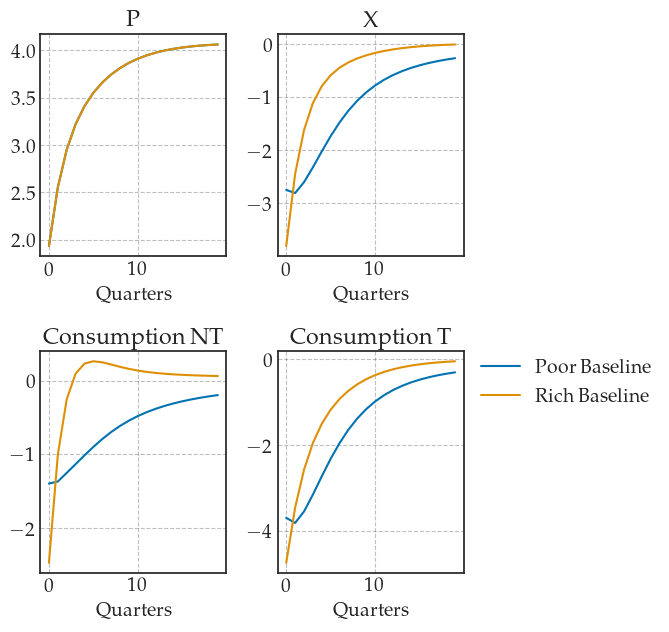

In [6]:
# fig = IRF_cohort_old(model_NH, shock, model_new)
# fig = IRF_cohort_old(model_CD, shock, model_homo=model_NH)
fig = IRF_cohort_old(model_CD, shock)

# Testing old to new

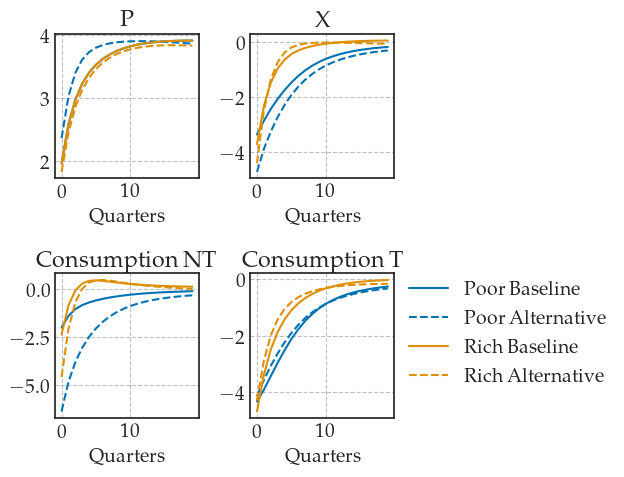

In [4]:
model_test = IHANKModelClass()



# Whiets
# model_test.par.nu = 0.7 # Scalling model_test.parameter
# model_test.par.alphaE = 0.05 # share of energy in tradable + energy consumption
# model_test.par.alphaF = 1/3 # share of foreign goods in home tradeable consumption




# Non-homothenticity
# model_test.par.epsilon = 0.18 # controls the degree of non-homotheticity 
# model_test.par.gamma = 0.29 # controls the non-constant elicticity of substitution  between tradable and non-tradable goods



# # Monetary policy
# model_test.par.mon_policy = 'taylor'
# # Variables Monitary policy  
# # model_test.par.rho_i = 0.9 # persistance of monetary policy
# model_test.par.phi_pi = 1.5 # inflation coefficient
# model_test.par.float = True # float or fix exchange rate
# model_test.par.phi = 1.5 # Taylor rule coefficient on inflation


# # Other elasticities
# model_test.par.etaE = 0.1 # elasticity of substitution between tradable goods and energy 
# model_test.par.etaF = 0.51 #*** # elasticity of substitution between home and foreign tradeable goods
# model_test.par.eta_s =  0.5 # # Armington elasticity of foreign demand


# model_test.par.real_wage_motive = 5.0



# # b. preferences
model_test.par.beta = 0.985 #0.975 # discount factor
# model_test.par.beta = 0.975 # discount factor
# model_test.par.kappa = 2.0 # Frisch elasticity of labor supply
        


# # c. income model_test.parameters
model_test.par.rho_z = 0.95 # AR(1) model_test.parameter
model_test.par.sigma_psi = 0.10 # std. of psi



# # d. price setting
# # NKWPC
# model_test.par.kappa_w = 0.05 # slope of wage Phillips curve
# model_test.par.mu_w = 1.2 # wage mark-up       

# # NKPC
# model_test.par.kappa_p = 0.1 # slope of price Phillips curve
# model_test.par.mu_p = 1.2 # wage mark-down



# # f. government
# model_test.par.tau_ss = 0.30 # tax rate on labor income
# model_test.par.omega = 0.10 # tax sensitivity to debt



model_test_CD = model_test.copy(name='CD')
model_test_CD.par.epsilon = 0.0
model_test_CD.par.gamma = 0.0



fig = figs.IRF_cohort_old(model_test_CD, shock, model_test)

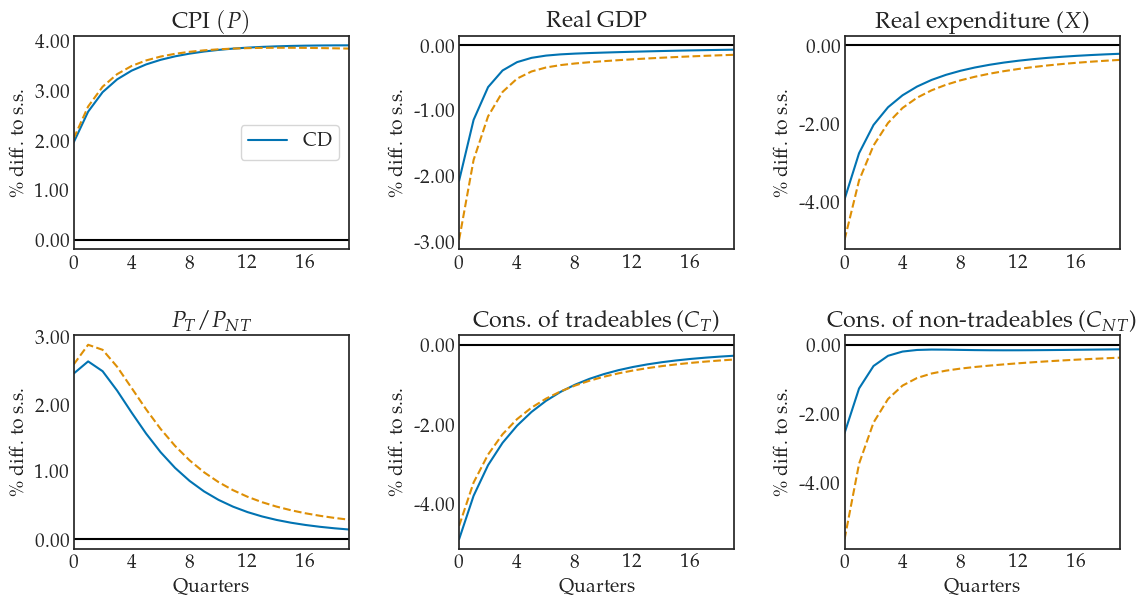

In [26]:
model_test.find_ss()
model_test.compute_jacs(do_print=False)
model_test.find_transition_path(shocks=shock, do_end_check=False, do_print=False)

model_test_CD.find_ss()
model_test_CD.compute_jacs(do_print=False)
model_test_CD.find_transition_path(shocks=shock, do_end_check=False, do_print=False)
paths = ['P', 'YH', 'X', 'p', 'CT', 'CNT']
fig = figs.show_IRFs([model_test_CD, model_test], paths)

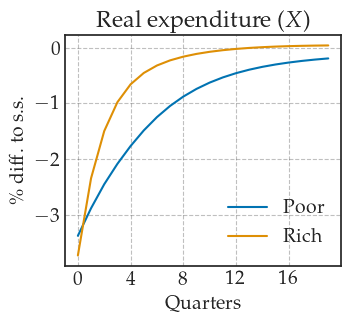

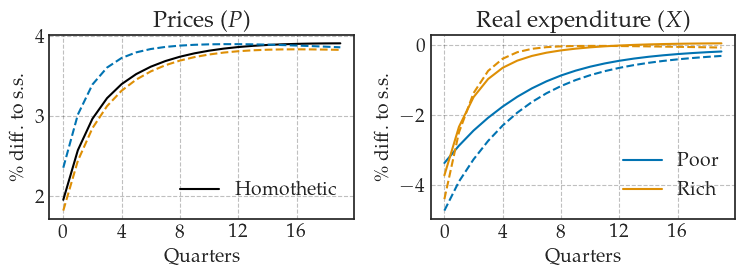

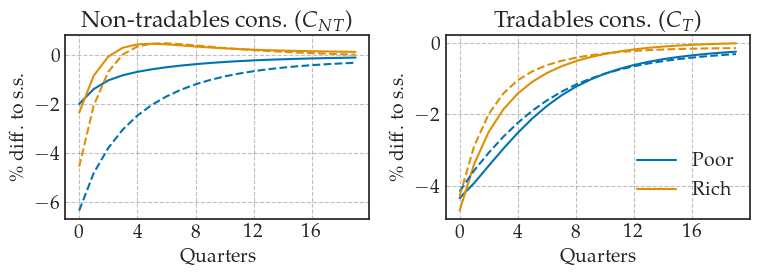

In [4]:
fig_1, fig_2, fig_3 = figs.show_states(model_test_CD, shock, model_test)

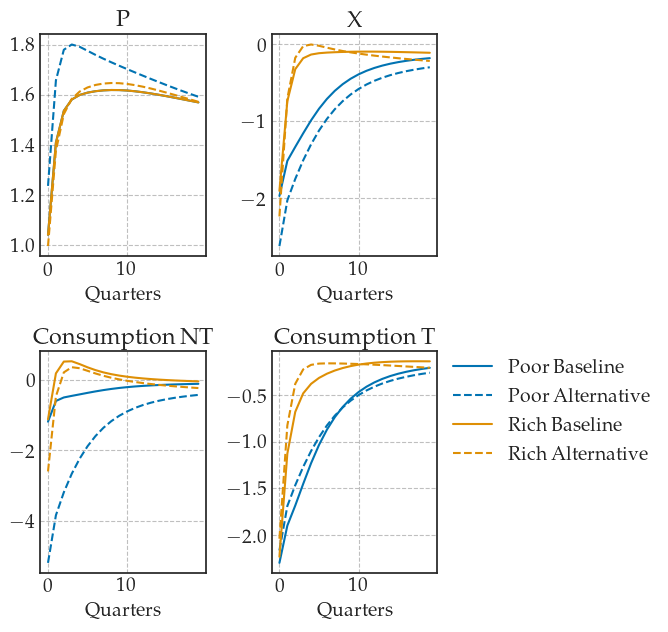

In [6]:
fig = IRF_cohort_old(model_CD, shock, model_test)

In [ ]:
fig = figs.IRF_cohort(model_CD, shock, model_homo = model_NH)

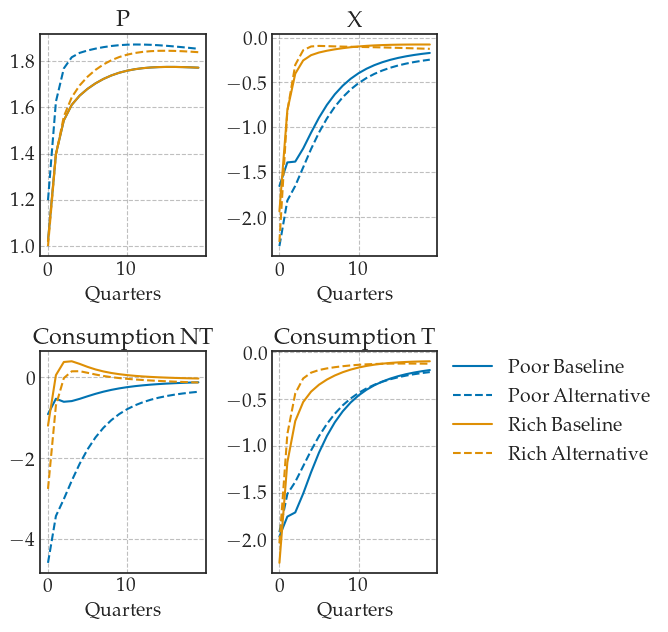

In [5]:
# OLD 1
model_ = IHANKModelClass(name='Model - test')


# 1. Wieghts
model_.par.nu = 0.7 # Scalling model_.parameter ***
model_.par.alphaE = 0.05 # share of energy in tradable + energy consumption
model_.par.alphaF = 1/3 # share of foreign goods in home tradeable consumption

# 2.  Non-homothenticity  
model_.par.epsilon = 0.18 # controls the degree of non-homotheticity 
model_.par.gamma = 0.29 # controls the non-constant elicticity of substitution  between tradable and non-tradable goods




# 3. Elasticities
# 3.1 Energy 
model_.par.etaE = 0.1 # elasticity of substitution between tradable goods and energy 

# 3.2 Trade elasticities 
model_.par.etaF = 0.51 #*** # elasticity of substitution between home and foreign tradeable goods
model_.par.eta_s =  0.5 # # Armington elasticity of foreign demand


# model_.par.phi_inflation = 1.0
model_.par.real_wage_motive = 5.0



# Variables Monitary policy  
model_.par.mon_policy = 'taylor' 
# model_.par.rho_i = 0.3 # persistance of monetary policy
model_.par.phi_pi = 1.5 # inflation coefficient

# b. preferences
# model_.par.beta = 0.985 #0.975 # discount factor

    
model_.par.varphiTH = np.nan # disutility of labor in tradeable sector (determined in s)
model_.par.varphiNT = np.nan # disutility of labor in non-tradeable sector (determined in s)
model_.par.kappa = 2.0 # Frisch elasticity of labor supply
        
# c. income model_.parameters
model_.par.rho_z = 0.95 # AR(1) model_.parameter
model_.par.sigma_psi = 0.10 # std. of psi

# d. price setting
# NKWPC
model_.par.kappa_w = 0.05 # slope of wage Phillips curve
model_.par.mu_w = 1.2 # wage mark-up       

# NKPC
model_.par.kappa_p = 0.1 # slope of price Phillips curve
model_.par.mu_p = 1.2 # wage mark-down

# e. foreign Economy



# f. government
model_.par.tau_ss = 0.30 # tax rate on labor income
model_.par.omega = 0.10 # tax sensitivity to debt




model_CD =  model_.copy(name='Test CD')

model_CD.par.epsilon = 0.0 # CES price index
model_CD.par.gamma = 0.0 # CES price index


fig = IRF_cohort_old(model_CD, shock, model_)

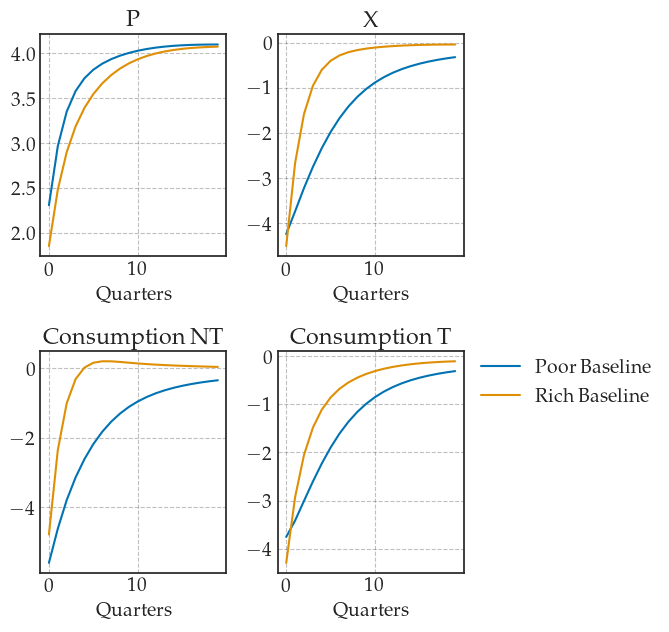

In [8]:

fig = IRF_cohort_old(model_NH, shock)

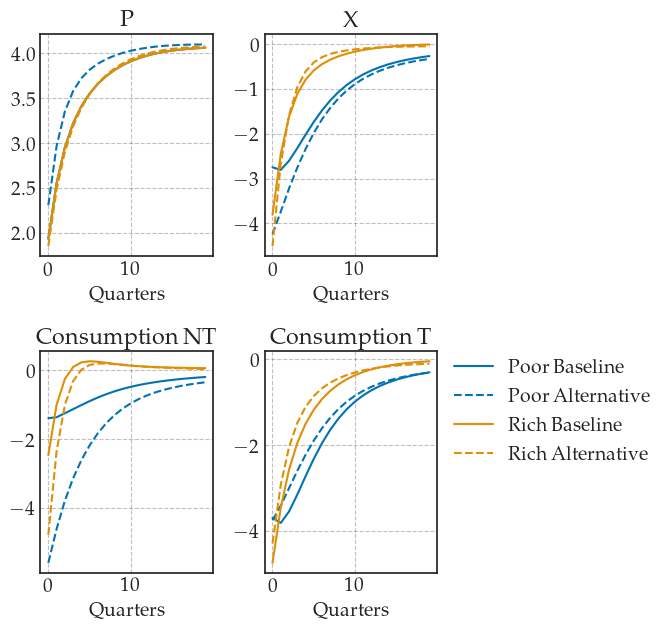

In [7]:
fig = fig = IRF_cohort_old(model_CD, shock, model_homo=model_NH)

In [ ]:
model_ = IHANKModelClass(name='Model - test')

# For tejkking 
# model_.par.alt = False
model_.par.sticky_prices = True
model_.par.real_exchange_rate_PTH  = False

# New 
model_.par.epsilon = 0.18 # controls the degree of non-homotheticity 
model_.par.gamma = 0.29 # controls the non-constant elicticity of substitution  between tradable and non-tradable goods
model_.par.nu = 0.7 # Scalling model_.parameter
model_.par.omega_T = np.nan # agregate expenditure share on tradables in steady state
model_.par.run_u = False
model_.par.mon_policy = 'taylor'
model_.par.pf_fixed = True
model_.par.etaE = 0.1 # elasticity of substitution between tradable goods and energy 
model_.par.alphaE = 0.05 # share of energy in tradable + energy consumption
model_.par.eta_T_RA = np.nan
# model_.par.phi_inflation = 1.0
model_.par.sNT = np.nan # share of Workers in the non-tradable sector - determined in ss
model_.par.pref = 'PIGL' # 'PIGL' or 'Cuub douglas'
model_.par.brute_force_C = False
model_.par.CES_price_index = False
model_.par.real_wage_motive = 5.0

# a. discrete states
model_.par.Nfix = 2 # number of sectors sectors
model_.par.Nz = 7 # idiosyncratic productivity
model_.par.sT = np.nan # share of workers in tradeable sector


# Variables Monitary policy  
# model_.par.rho_i = 0.3 # persistance of monetary policy
model_.par.phi_pi = 1.5 # inflation coefficient

# b. preferences
model_.par.beta = 0.985 #0.975 # discount factor
# model_.par.sigma = 2.0 # inverse of intertemporal elasticity of substitution

# model_.par.alphaT = np.nan # share of tradeable goods in home consumption (determined in ss)
# model_.par.etaT = 0.5 #2.0 # elasticity of substitution between tradeable and non-tradeable goods

model_.par.alphaF = 1/3 # share of foreign goods in home tradeable consumption
model_.par.etaF = 0.51 #*** # elasticity of substitution between home and foreign tradeable goods
    
model_.par.varphiTH = np.nan # disutility of labor in tradeable sector (determined in s)
model_.par.varphiNT = np.nan # disutility of labor in non-tradeable sector (determined in s)
model_.par.kappa = 2.0 # Frisch elasticity of labor supply
        
# c. income model_.parameters
model_.par.rho_z = 0.95 # AR(1) model_.parameter
model_.par.sigma_psi = 0.10 # std. of psi

# d. price setting
# NKWPC
model_.par.kappa_w = 0.05 # slope of wage Phillips curve
model_.par.mu_w = 1.2 # wage mark-up       

# NKPC
model_.par.kappa_p = 0.1 # slope of price Phillips curve
model_.par.mu_p = 1.2 # wage mark-down

# e. foreign Economy

model_.par.eta_s =  0.5 # # Armington elasticity of foreign demand


# f. government
model_.par.tau_ss = 0.30 # tax rate on labor income
model_.par.omega = 0.10 # tax sensitivity to debt



# # Non Homothenticity  
# model_.par.epsilon = 0.18 # controls the degree of non-homotheticity 
# model_.par.gamma = 0.29 # controls the non-constant elicticity of substitution  between tradable and non-tradable goods

# model_.par.mon_policy = 'taylor'

# model_.par.etaE = 0.1 # elasticity of substitution between tradable goods and energy 

# model_.par.real_wage_motive = 5.0


# # b. preferences
# model_.par.beta = 0.985 # discount factor


# # # c. income model_.parameters
# model_.par.rho_z = 0.95 # AR(1) model_.parameter
# model_.par.sigma_psi = 0.10 # std. of psi

# # d. price setting
# # NKWPC
# model_.par.kappa_w = 0.05 # slope of wage Phillips curve
# model_.par.mu_w = 1.2 # wage mark-up       

# # NKPC
# model_.par.kappa_p = 0.1 # slope of price Phillips curve
# model_.par.mu_p = 1.2 # wage mark-down

# # e. foreign Economy

# model_.par.eta_s =  0.5 # # Armington elasticity of foreign demand


# # f. government
# model_.par.tau_ss = 0.30 # tax rate on labor income
# model_.par.omega = 0.10 # tax sensitivity to debt


model_CD =  model_.copy(name='Test CD')

model_CD.par.epsilon = 0.0 # CES price index
model_CD.par.gamma = 0.0 # CES price index


fig = IRF_cohort_old(model_CD, shock, model_)

In [ ]:
model_old_homo =  model_NH.copy(name='Old model parameters CD')
model_old_homo.par.epsilon = 0.0 # CES price index
model_old_homo.par.gamma = 0.0 # CES price index

In [ ]:
# paths_ =  ['P', 'W', 'w', 'X', 'YH', 'N', 'r_real', 'A_real', 'E']
paths_ =  ['P', 'W', 'w', 'X', 'YH', 'N', 'r_real', 'A_hh', 'E', 'div_NT', 'div_TH']
# Want W, N, Y, 
fig = figs.show_IRFs([model_NH], paths_, T_max=T_max_)

In [ ]:
fig = IRF_cohort_old(model_CD, shock, model_homo=model_NH)

In [ ]:
fig = IRF_cohort_old(model_old, shock)

In [ ]:
fig = IRF_cohort_old(model_old_CD, shock)

In [ ]:
fig = IRF_cohort_old(model_old, shock, model_homo=model_old_CD)

In [22]:
model_old = IHANKModelClass(name='Old model parameters')


# For tejkking 
# model_old.par.alt = False
model_old.par.sticky_prices = True
model_old.par.real_exchange_rate_PTH  = False

# New 
model_old.par.epsilon = 0.18 # controls the degree of non-homotheticity 
model_old.par.gamma = 0.29 # controls the non-constant elicticity of substitution  between tradable and non-tradable goods
model_old.par.nu = 0.7 # Scalling model_old.parameter
model_old.par.omega_T = np.nan # agregate expenditure share on tradables in steady state
model_old.par.run_u = False
model_old.par.mon_policy = 'taylor'
model_old.par.pf_fixed = True
model_old.par.etaE = 0.1 # elasticity of substitution between tradable goods and energy 
model_old.par.alphaE = 0.05 # share of energy in tradable + energy consumption
model_old.par.eta_T_RA = np.nan
# model_old.par.phi_inflation = 1.0
model_old.par.sNT = np.nan # share of Workers in the non-tradable sector - determined in ss
model_old.par.pref = 'PIGL' # 'PIGL' or 'Cuub douglas'
model_old.par.brute_force_C = False
model_old.par.CES_price_index = False
model_old.par.real_wage_motive = 5.0

# a. discrete states
model_old.par.Nfix = 2 # number of sectors sectors
model_old.par.Nz = 7 # idiosyncratic productivity
model_old.par.sT = np.nan # share of workers in tradeable sector


# Variables Monitary policy  
# model_old.par.rho_i = 0.3 # persistance of monetary policy
model_old.par.phi_pi = 1.5 # inflation coefficient

# b. preferences
model_old.par.beta = 0.985 #0.975 # discount factor
# model_old.par.sigma = 2.0 # inverse of intertemporal elasticity of substitution

# model_old.par.alphaT = np.nan # share of tradeable goods in home consumption (determined in ss)
# model_old.par.etaT = 0.5 #2.0 # elasticity of substitution between tradeable and non-tradeable goods

model_old.par.alphaF = 1/3 # share of foreign goods in home tradeable consumption
model_old.par.etaF = 0.51 #*** # elasticity of substitution between home and foreign tradeable goods
    
model_old.par.varphiTH = np.nan # disutility of labor in tradeable sector (determined in s)
model_old.par.varphiNT = np.nan # disutility of labor in non-tradeable sector (determined in s)
model_old.par.kappa = 2.0 # Frisch elasticity of labor supply
        
# c. income model_old.parameters
model_old.par.rho_z = 0.95 # AR(1) model_old.parameter
model_old.par.sigma_psi = 0.10 # std. of psi

# d. price setting
# NKWPC
model_old.par.kappa_w = 0.05 # slope of wage Phillips curve
model_old.par.mu_w = 1.2 # wage mark-up       

# NKPC
model_old.par.kappa_p = 0.1 # slope of price Phillips curve
model_old.par.mu_p = 1.2 # wage mark-down

# e. foreign Economy

model_old.par.eta_s =  0.5 # # Armington elasticity of foreign demand


# f. government
model_old.par.tau_ss = 0.30 # tax rate on labor income
model_old.par.omega = 0.10 # tax sensitivity to debt


In [26]:
# Changes from old 
model_old.par.alphaE = model_NH.par.alphaE# share of energy in tradable + energy consumption
model_old.par.nu = model_NH.par.nu # Scalling model_old.parameter
model_old.par.alphaF = model_NH.par.alphaF # share of foreign goods in home tradeable consumption

# model_old.par.mon_policy = 'taylor_persistence'
# model_old.par.rho_i = model_NH.par.rho_i # inflation coefficient (0.3)


# model_old.par.kappa_p = model_NH.par.kappa_p # slope of price Phillips curve
# model_old.par.mu_p = model_NH.par.mu_p # price mark-down

model_old.par.kappa_w = model_NH.par.kappa_w # slope of price Phillips curve
model_old.par.kappa_p = model_NH.par.kappa_p # slope of price Phillips curve


In [27]:
model_old_CD =  model_old.copy(name='Old model parameters CD')
model_old_CD.par.epsilon = 0.0 # CES price index
model_old_CD.par.gamma = 0.0 # CES price index

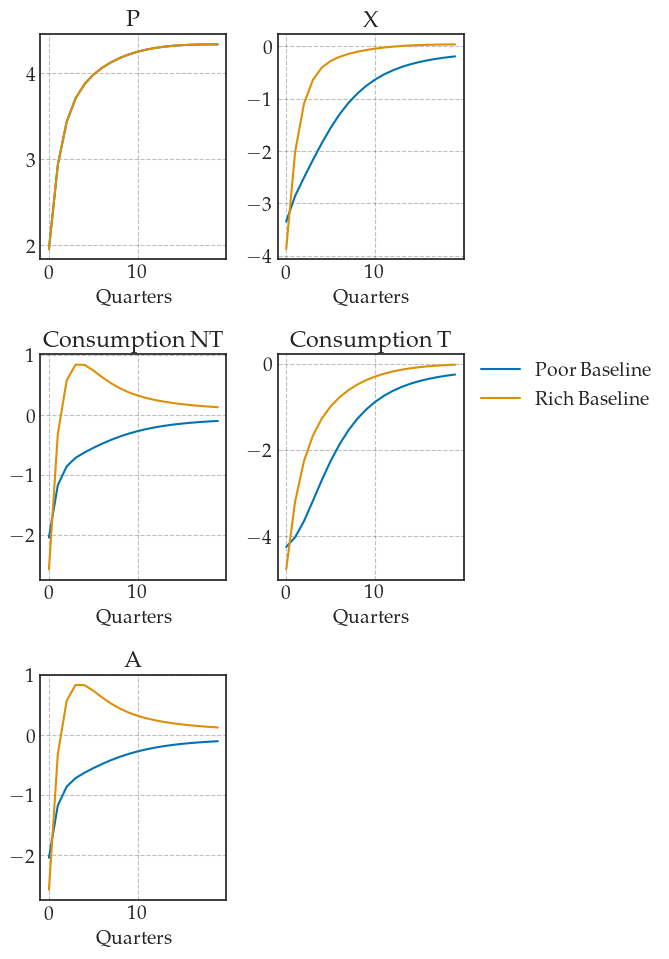

In [28]:
fig = IRF_cohort_old(model_old_CD, shock)

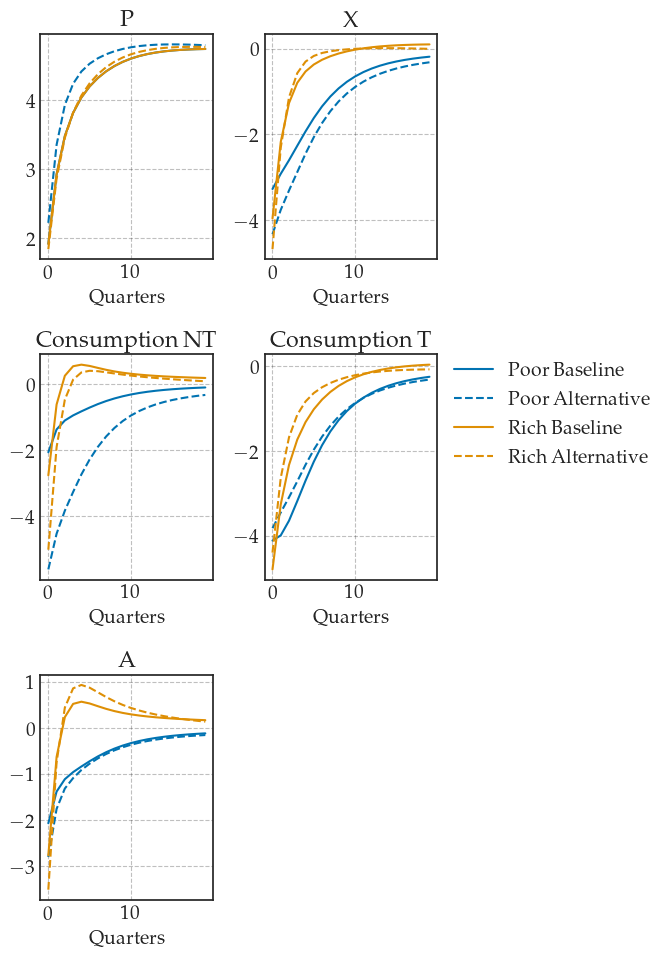

In [20]:

fig = IRF_cohort_old(model_old_CD, shock, model_homo=model_old)

In [ ]:
model_old.find_ss()
model_old.compute_jacs(do_print=False)
model_old.find_transition_path(shocks=shock, do_end_check=False, do_print=False)

In [ ]:
# paths_ =  ['P', 'W', 'w', 'X', 'YH', 'N', 'r_real', 'A_real', 'E']
paths_ =  ['PE_s', 'P', 'W', 'w', 'X', 'YH', 'N', 'r_real', 'A_hh', 'E', 'div_NT', 'div_TH', 'p']
# Want W, N, Y, 
fig = figs.show_IRFs([model_NH, model_old], paths_, T_max=T_max_)